In [39]:
from google.colab import drive

In [40]:
!pip install lime

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from imblearn.combine import SMOTETomek
import warnings
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
from imblearn.combine import SMOTETomek
import lime.lime_tabular
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer

In [5]:
df=pd.read_csv('/content/drive/MyDrive/ML DATASETS/expe.csv')
df

LAST_POLL  VMID     dom    rxbytes  rxpackets       txbytes  txpackets  \
0     1604406033     7  one-33      36199        606  2.108000e+03         32   
1     1604406062     7  one-33      37039        622  2.240000e+03         34   
2     1604406092     7  one-33      37969        639  2.372000e+03         36   
3     1604406122     7  one-33      38809        655  2.372000e+03         36   
4     1604406153     7  one-33      39589        670  2.442000e+03         37   
...          ...   ...     ...        ...        ...           ...        ...   
9605  1604635532     6  one-43  249706534     224881  1.290000e+11  742023775   
9606  1604635562     6  one-43  249707356     224897  1.290000e+11  742666481   
9607  1604635592     6  one-43  249708178     224913  1.290000e+11  743078195   
9608  1604635622     6  one-43  249709000     224929  1.290000e+11  743699492   
9609  1604635652     6  one-43  249709924     224947  1.290000e+11  744251447   

           timecpu       timesys       timeusr  ...  memusable  \
0     1.020000e+12  6.070000e+09  4.420000e+09  ...     603072   
1     1.040000e+12  6.120000e+09  4.450000e+09  ...     603072   
2     1.060000e+12  6.190000e+09  4.490000e+09  ...     603072   
3     1.080000e+12  6.240000e+09  4.550000e+09  ...     603072   
4     1.100000e+12  6.320000e+09  4.620000e+09  ...     603072   
...            ...           ...           ...  ...        ...   
9605  4.790000e+13  1.450000e+13  4.760000e+12  ...     603132   
9606  4.800000e+13  1.460000e+13  4.760000e+12  ...     603132   
9607  4.800000e+13  1.460000e+13  4.760000e+12  ...     603132   
9608  4.800000e+13  1.460000e+13  4.770000e+12  ...     603132   
9609  4.800000e+13  1.460000e+13  4.770000e+12  ...     603132   

      memlast_update  memrss  vdard_req  vdard_bytes  vdawr_reqs  vdawr_bytes  \
0         1604405004  480732       5896    176581632        3475     37070336   
1         1604405004  480732       5896    176581632        3521     37385728   
2         1604405004  480984       5896    176581632        3684     39052800   
3         1604405004  480984       5896    176581632        3714     39269888   
4         1604405004  480880       5896    176581632        3831     40703488   
...              ...     ...        ...          ...         ...          ...   
9605      1604587567  822896      20509    737603584       89969   3187705344   
9606      1604587567  822896      20509    737603584       89982   3187807744   
9607      1604587567  822884      20509    737603584       90001   3187901952   
9608      1604587567  822884      20509    737603584       90001   3187901952   
9609      1604587567  822884      20509    737603584       90001   3187901952   

      hdard_req  hdard_bytes  Status  
0           148       506260  Normal  
1           148       506260  Normal  
2           148       506260  Normal  
3           148       506260  Normal  
4           148       506260  Normal  
...         ...          ...     ...  
9605        229       766668  Attack  
9606        229       766668  Attack  
9607        229       766668  Attack  
9608        229       766668  Attack  
9609        229       766668  Attack  

[9610 rows x 24 columns]

In [6]:
# Ensure the LAST_POLL column is sorted
df.sort_values(by='LAST_POLL')

# Calculate the time difference in seconds
df['time_diff'] = df['LAST_POLL'].diff() / 60  # Convert time diff to minutes

# Normalize the cumulative columns
cumulative_columns = ['rxbytes', 'rxpackets','txbytes','txpackets','vdard_req','vdard_bytes','vdawr_reqs','vdawr_bytes','hdard_req','hdard_bytes']  # Add more as needed

for column in cumulative_columns:
    # Calculate the rate of change
    df[f'{column}_rate'] = df[column].diff() / df['time_diff']

# Fill NaN values (from the first row) with 0 or a suitable value
df.fillna(0, inplace=True)

# Save the normalized dataset
df.to_csv('/content/drive/MyDrive/ML DATASETS/normalized_data.csv', index=False)

# Display the updated dataframe
print(df.head())

    LAST_POLL  VMID     dom  rxbytes  rxpackets  txbytes  txpackets  \
0  1604406033     7  one-33    36199        606   2108.0         32   
1  1604406062     7  one-33    37039        622   2240.0         34   
2  1604406092     7  one-33    37969        639   2372.0         36   
3  1604406122     7  one-33    38809        655   2372.0         36   
4  1604406153     7  one-33    39589        670   2442.0         37   

        timecpu       timesys       timeusr  ...  rxbytes_rate  \
0  1.020000e+12  6.070000e+09  4.420000e+09  ...      0.000000   
1  1.040000e+12  6.120000e+09  4.450000e+09  ...   1737.931034   
2  1.060000e+12  6.190000e+09  4.490000e+09  ...   1860.000000   
3  1.080000e+12  6.240000e+09  4.550000e+09  ...   1680.000000   
4  1.100000e+12  6.320000e+09  4.620000e+09  ...   1509.677419   

   rxpackets_rate  txbytes_rate  txpackets_rate  vdard_req_rate  \
0        0.000000      0.000000        0.000000             0.0   
1       33.103448    273.103448        4.1

In [7]:
# Load the normalized dataset
df = pd.read_csv('/content/drive/MyDrive/ML DATASETS/normalized_data.csv')

# Define the columns you want to keep
new_columns = ['LAST_POLL','VMID','rxbytes_rate','rxpackets_rate','txbytes_rate','txpackets_rate','timecpu','timesys','timeusr','state','cputime','memminor_fault','memunused','memusable','memlast_update','memrss','vdard_req_rate','vdard_bytes_rate','vdawr_reqs_rate','vdawr_bytes_rate','hdard_req_rate','hdard_bytes_rate','Status']  # 'rxbytes_rate' was created during normalization

# Select only the desired columns
df = df[new_columns]

# Display the DataFrame
df

LAST_POLL  VMID  rxbytes_rate  rxpackets_rate  txbytes_rate  \
0     1604406033     7      0.000000        0.000000      0.000000   
1     1604406062     7   1737.931034       33.103448    273.103448   
2     1604406092     7   1860.000000       34.000000    264.000000   
3     1604406122     7   1680.000000       32.000000      0.000000   
4     1604406153     7   1509.677419       29.032258    135.483871   
...          ...   ...           ...             ...           ...   
9605  1604635532     6   1590.967742       30.967742      0.000000   
9606  1604635562     6   1644.000000       32.000000      0.000000   
9607  1604635592     6   1644.000000       32.000000      0.000000   
9608  1604635622     6   1644.000000       32.000000      0.000000   
9609  1604635652     6   1848.000000       36.000000      0.000000   

      txpackets_rate       timecpu       timesys       timeusr  state  ...  \
0       0.000000e+00  1.020000e+12  6.070000e+09  4.420000e+09      1  ...   
1       4.137931e+00  1.040000e+12  6.120000e+09  4.450000e+09      1  ...   
2       4.000000e+00  1.060000e+12  6.190000e+09  4.490000e+09      1  ...   
3       0.000000e+00  1.080000e+12  6.240000e+09  4.550000e+09      1  ...   
4       1.935484e+00  1.100000e+12  6.320000e+09  4.620000e+09      1  ...   
...              ...           ...           ...           ...    ...  ...   
9605    9.421084e+05  4.790000e+13  1.450000e+13  4.760000e+12      1  ...   
9606    1.285412e+06  4.800000e+13  1.460000e+13  4.760000e+12      1  ...   
9607    8.234280e+05  4.800000e+13  1.460000e+13  4.760000e+12      1  ...   
9608    1.242594e+06  4.800000e+13  1.460000e+13  4.770000e+12      1  ...   
9609    1.103910e+06  4.800000e+13  1.460000e+13  4.770000e+12      1  ...   

      memusable  memlast_update  memrss  vdard_req_rate  vdard_bytes_rate  \
0        603072      1604405004  480732             0.0               0.0   
1        603072      1604405004  480732             0.0               0.0   
2        603072      1604405004  480984             0.0               0.0   
3        603072      1604405004  480984             0.0               0.0   
4        603072      1604405004  480880             0.0               0.0   
...         ...             ...     ...             ...               ...   
9605     603132      1604587567  822896             0.0               0.0   
9606     603132      1604587567  822896             0.0               0.0   
9607     603132      1604587567  822884             0.0               0.0   
9608     603132      1604587567  822884             0.0               0.0   
9609     603132      1604587567  822884             0.0               0.0   

      vdawr_reqs_rate  vdawr_bytes_rate  hdard_req_rate  hdard_bytes_rate  \
0            0.000000      0.000000e+00             0.0               0.0   
1           95.172414      6.525352e+05             0.0               0.0   
2          326.000000      3.334144e+06             0.0               0.0   
3           60.000000      4.341760e+05             0.0               0.0   
4          226.451613      2.774710e+06             0.0               0.0   
...               ...               ...             ...               ...   
9605        75.483871      4.835923e+05             0.0               0.0   
9606        26.000000      2.048000e+05             0.0               0.0   
9607        38.000000      1.884160e+05             0.0               0.0   
9608         0.000000      0.000000e+00             0.0               0.0   
9609         0.000000      0.000000e+00             0.0               0.0   

      Status  
0     Normal  
1     Normal  
2     Normal  
3     Normal  
4     Normal  
...      ...  
9605  Attack  
9606  Attack  
9607  Attack  
9608  Attack  
9609  Attack  

[9610 rows x 23 columns]

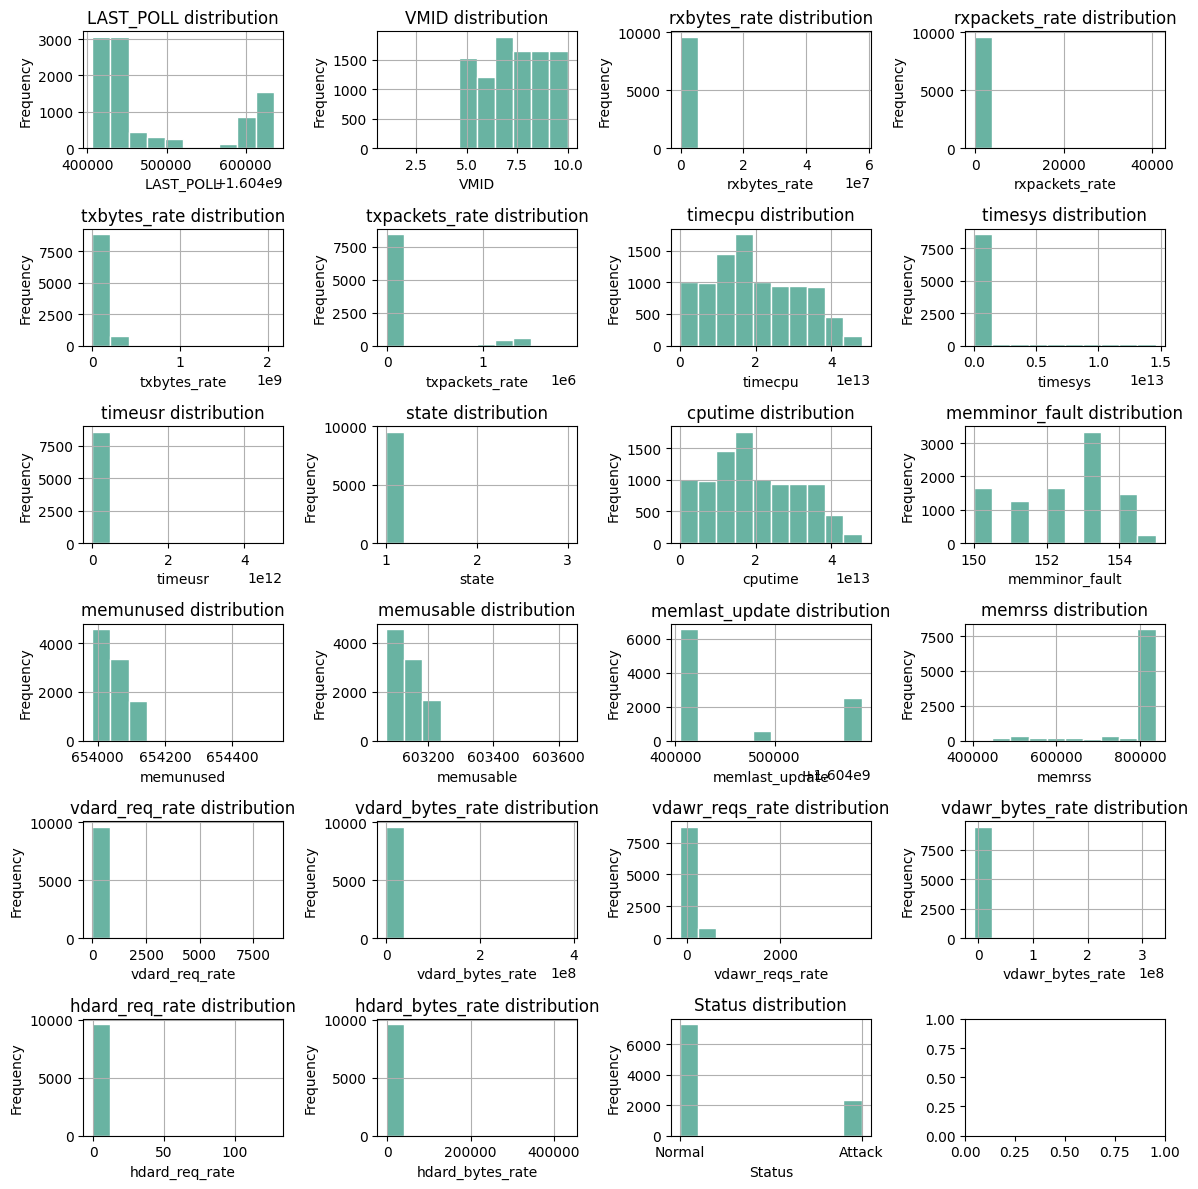

In [8]:
# Initialize a 3x3 charts
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(12, 12)) # Increase the number of rows to 6 to accommodate all 23 columns

# Flatten the axes array (makes it easier to iterate over)
axes = axes.flatten()

# Loop through each column and plot a histogram
for i, column in enumerate(df.columns):
    # Add the histogram
    df[column].hist(ax=axes[i], # Define on which ax we're working on
                    edgecolor='white', # Color of the border
                    color='#69b3a2' # Color of the bins
                   )

    # Add title and axis label
    axes[i].set_title(f'{column} distribution')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

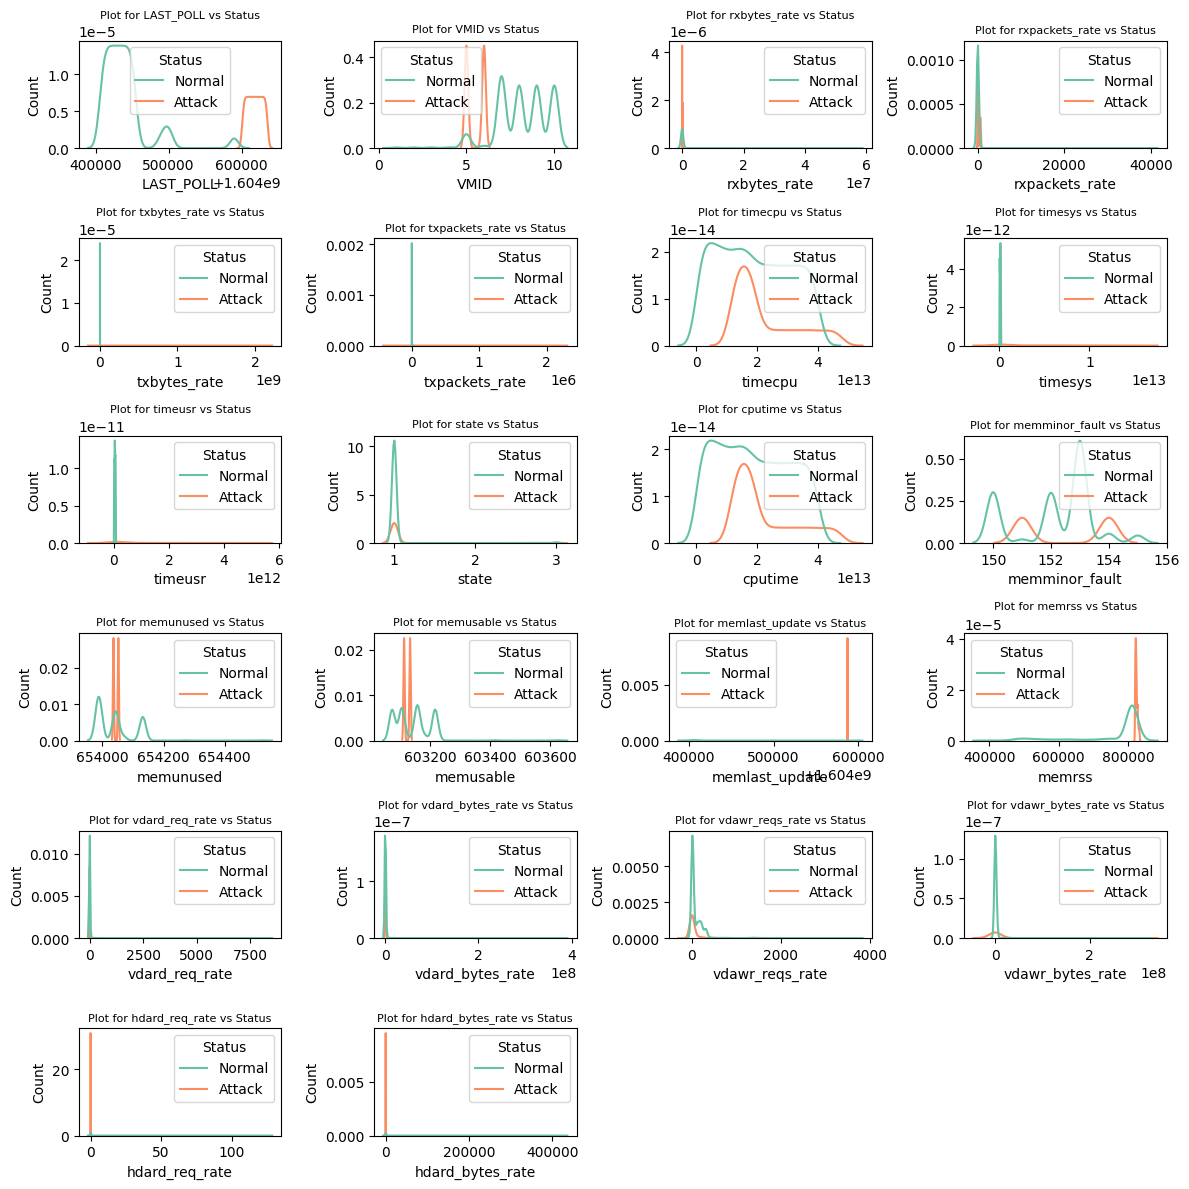

In [9]:
numerical_cols =['LAST_POLL','VMID','rxbytes_rate','rxpackets_rate','txbytes_rate','txpackets_rate','timecpu','timesys','timeusr','state','cputime','memminor_fault','memunused','memusable','memlast_update','memrss','vdard_req_rate','vdard_bytes_rate','vdawr_reqs_rate','vdawr_bytes_rate','hdard_req_rate','hdard_bytes_rate']
# Set up the matplotlib figure
plt.figure(figsize=(12, 12))
# Create count plots for each numerical feature
# Adjust the subplot grid to accommodate all 22 features (e.g., 6 rows x 4 columns)
for i, feature in enumerate(numerical_cols):
    plt.subplot(6, 4, i + 1)  # Changed to 6 rows, 4 columns to fit all features
    sns.kdeplot(data=df, x=feature, hue='Status', palette='Set2')
    plt.title(f'Plot for {feature} vs Status', fontsize=8)
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [10]:
#lets fill in missing values
# List of rate columns where zeros need to be replaced
rate_columns = [
    'rxbytes_rate', 'rxpackets_rate', 'txbytes_rate', 'txpackets_rate',
    'vdard_req_rate', 'vdard_bytes_rate', 'vdawr_reqs_rate',
    'vdawr_bytes_rate', 'hdard_req_rate', 'hdard_bytes_rate'
]

# Replace zeros with a small non-zero value for each column
for column in rate_columns:
    # Calculate a small fraction of the mean of non-zero values in the column
    small_value = df[df[column] > 0][column].mean() * 0.1  # 10% of the mean
    # Replace zeros with the small value
    df[column] = df[column].replace(0, small_value)

# Display the updated DataFrame
print(df.head())


    LAST_POLL  VMID  rxbytes_rate  rxpackets_rate  txbytes_rate  \
0  1604406033     7   9688.779529       15.773351  7.068319e+06   
1  1604406062     7   1737.931034       33.103448  2.731034e+02   
2  1604406092     7   1860.000000       34.000000  2.640000e+02   
3  1604406122     7   1680.000000       32.000000  7.068319e+06   
4  1604406153     7   1509.677419       29.032258  1.354839e+02   

   txpackets_rate       timecpu       timesys       timeusr  state  ...  \
0    38291.334424  1.020000e+12  6.070000e+09  4.420000e+09      1  ...   
1        4.137931  1.040000e+12  6.120000e+09  4.450000e+09      1  ...   
2        4.000000  1.060000e+12  6.190000e+09  4.490000e+09      1  ...   
3    38291.334424  1.080000e+12  6.240000e+09  4.550000e+09      1  ...   
4        1.935484  1.100000e+12  6.320000e+09  4.620000e+09      1  ...   

   memusable  memlast_update  memrss  vdard_req_rate  vdard_bytes_rate  \
0     603072      1604405004  480732       23.778828      1.334142e+06  

In [11]:
df.head()

LAST_POLL  VMID  rxbytes_rate  rxpackets_rate  txbytes_rate  \
0  1604406033     7   9688.779529       15.773351  7.068319e+06   
1  1604406062     7   1737.931034       33.103448  2.731034e+02   
2  1604406092     7   1860.000000       34.000000  2.640000e+02   
3  1604406122     7   1680.000000       32.000000  7.068319e+06   
4  1604406153     7   1509.677419       29.032258  1.354839e+02   

   txpackets_rate       timecpu       timesys       timeusr  state  ...  \
0    38291.334424  1.020000e+12  6.070000e+09  4.420000e+09      1  ...   
1        4.137931  1.040000e+12  6.120000e+09  4.450000e+09      1  ...   
2        4.000000  1.060000e+12  6.190000e+09  4.490000e+09      1  ...   
3    38291.334424  1.080000e+12  6.240000e+09  4.550000e+09      1  ...   
4        1.935484  1.100000e+12  6.320000e+09  4.620000e+09      1  ...   

   memusable  memlast_update  memrss  vdard_req_rate  vdard_bytes_rate  \
0     603072      1604405004  480732       23.778828      1.334142e+06   
1     603072      1604405004  480732       23.778828      1.334142e+06   
2     603072      1604405004  480984       23.778828      1.334142e+06   
3     603072      1604405004  480984       23.778828      1.334142e+06   
4     603072      1604405004  480880       23.778828      1.334142e+06   

   vdawr_reqs_rate  vdawr_bytes_rate  hdard_req_rate  hdard_bytes_rate  Status  
0         9.575057      5.201945e+05         3.78231      12314.610938  Normal  
1        95.172414      6.525352e+05         3.78231      12314.610938  Normal  
2       326.000000      3.334144e+06         3.78231      12314.610938  Normal  
3        60.000000      4.341760e+05         3.78231      12314.610938  Normal  
4       226.451613      2.774710e+06         3.78231      12314.610938  Normal  

[5 rows x 23 columns]

In [12]:
# Lets know the columns existing in the dataframe
df.columns

Index(['LAST_POLL', 'VMID', 'rxbytes_rate', 'rxpackets_rate', 'txbytes_rate',
       'txpackets_rate', 'timecpu', 'timesys', 'timeusr', 'state', 'cputime',
       'memminor_fault', 'memunused', 'memusable', 'memlast_update', 'memrss',
       'vdard_req_rate', 'vdard_bytes_rate', 'vdawr_reqs_rate',
       'vdawr_bytes_rate', 'hdard_req_rate', 'hdard_bytes_rate', 'Status'],
      dtype='object')

In [13]:
# we have excluded the TARGET variable because we want to generte a heatmap which only takes in numerical variable
dfn=df[['VMID', 'rxbytes_rate', 'rxpackets_rate', 'txbytes_rate',
       'txpackets_rate', 'timecpu', 'timesys', 'timeusr', 'state', 'cputime',
       'memminor_fault', 'memunused', 'memusable', 'memlast_update', 'memrss',
       'vdard_req_rate', 'vdard_bytes_rate', 'vdawr_reqs_rate',
       'vdawr_bytes_rate', 'hdard_req_rate', 'hdard_bytes_rate']]

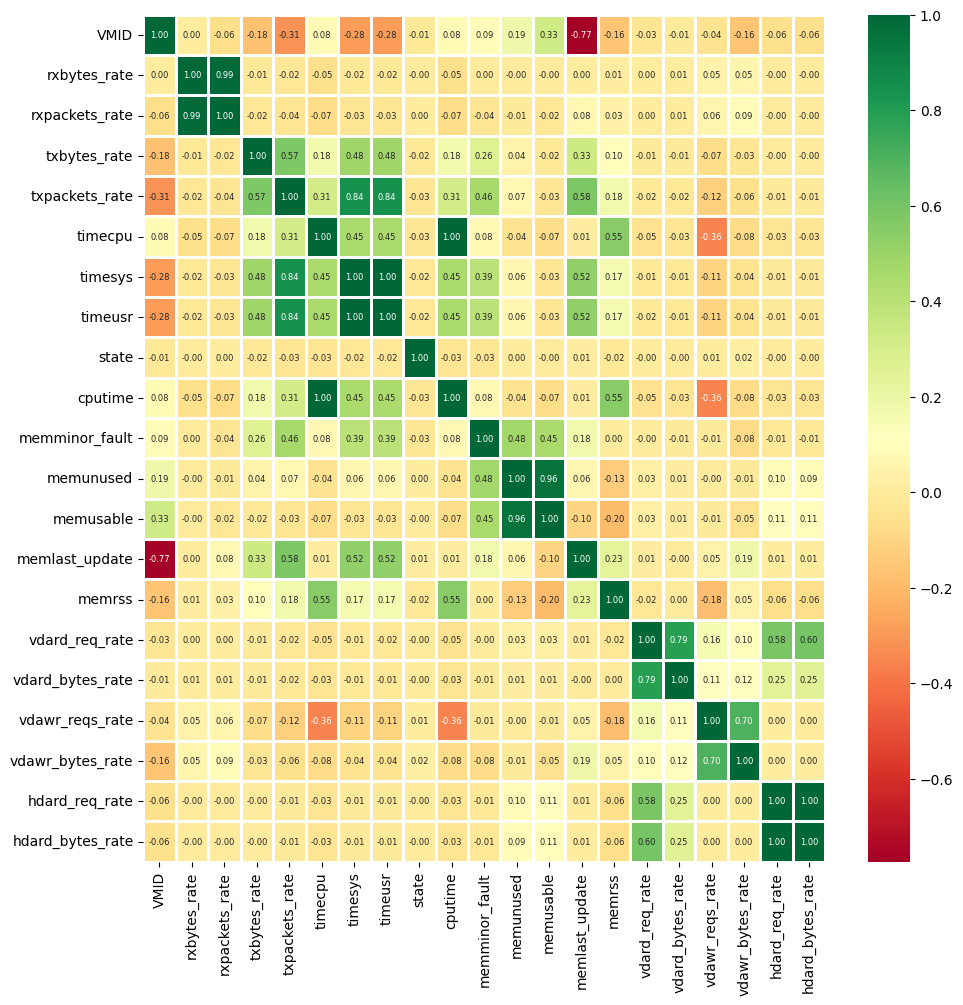

In [14]:
#Plot correlation matrix
plt.figure(figsize=(11, 11))
sns.heatmap(dfn.corr(), linewidth=1, annot=True,fmt=".2f",cmap="RdYlGn", annot_kws={"size":6})
plt.show()

In [15]:
# lets copy df to another dataframe model_df to be used for model training
model_df=df.copy()

In [16]:
model_df.columns

Index(['LAST_POLL', 'VMID', 'rxbytes_rate', 'rxpackets_rate', 'txbytes_rate',
       'txpackets_rate', 'timecpu', 'timesys', 'timeusr', 'state', 'cputime',
       'memminor_fault', 'memunused', 'memusable', 'memlast_update', 'memrss',
       'vdard_req_rate', 'vdard_bytes_rate', 'vdawr_reqs_rate',
       'vdawr_bytes_rate', 'hdard_req_rate', 'hdard_bytes_rate', 'Status'],
      dtype='object')

**MODEL BUILDING**

In [17]:
#Splitting the model_df dataset into features and target
X = model_df.drop(columns=['LAST_POLL','VMID','Status'])  # Features
y = model_df['Status']  # Target

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [19]:
# Combine X_test and y_test
combined_dataset = pd.concat([pd.DataFrame(X_test), pd.Series(y_test.squeeze(), name='target')], axis=1)

# Display the combined dataset
print(combined_dataset.head())
combined_dataset =pd.DataFrame(combined_dataset)
combined_dataset

      rxbytes_rate  rxpackets_rate  txbytes_rate  txpackets_rate  \
3051   1506.206897       28.965517  7.068319e+06    3.829133e+04   
3858   1800.000000       34.000000  7.068319e+06    3.829133e+04   
4222   1560.000000       30.000000  7.068319e+06    3.829133e+04   
2412   1610.322581       30.967742  7.068319e+06    3.829133e+04   
9090   1590.967742       30.967742  2.298697e+08    1.321092e+06   

           timecpu       timesys       timeusr  state       cputime  \
3051  3.520000e+13  1.540000e+11  5.837000e+10      1  3.520000e+13   
3858  7.410000e+12  3.525000e+10  1.802000e+10      1  7.410000e+12   
4222  1.620000e+13  8.382000e+10  3.323000e+10      1  1.620000e+13   
2412  1.960000e+13  9.265000e+10  3.594000e+10      1  1.960000e+13   
9090  3.140000e+13  8.110000e+12  2.660000e+12      1  3.140000e+13   

      memminor_fault  ...  memusable  memlast_update  memrss  vdard_req_rate  \
3051             150  ...     603104      1604405111  812388       23.778828   
3858

rxbytes_rate  rxpackets_rate  txbytes_rate  txpackets_rate  \
3051   1506.206897       28.965517  7.068319e+06    3.829133e+04   
3858   1800.000000       34.000000  7.068319e+06    3.829133e+04   
4222   1560.000000       30.000000  7.068319e+06    3.829133e+04   
2412   1610.322581       30.967742  7.068319e+06    3.829133e+04   
9090   1590.967742       30.967742  2.298697e+08    1.321092e+06   
...            ...             ...           ...             ...   
2667   1560.000000       30.000000  7.068319e+06    3.829133e+04   
9321   1764.000000       34.000000  2.318210e+08    1.332306e+06   
2943   1506.206897       28.965517  7.068319e+06    3.829133e+04   
3169   1688.571429       32.142857  7.068319e+06    3.829133e+04   
3125   1560.000000       30.000000  7.068319e+06    3.829133e+04   

           timecpu       timesys       timeusr  state       cputime  \
3051  3.520000e+13  1.540000e+11  5.837000e+10      1  3.520000e+13   
3858  7.410000e+12  3.525000e+10  1.802000e+10      1  7.410000e+12   
4222  1.620000e+13  8.382000e+10  3.323000e+10      1  1.620000e+13   
2412  1.960000e+13  9.265000e+10  3.594000e+10      1  1.960000e+13   
9090  3.140000e+13  8.110000e+12  2.660000e+12      1  3.140000e+13   
...            ...           ...           ...    ...           ...   
2667  2.570000e+13  1.150000e+11  4.466000e+10      1  2.570000e+13   
9321  3.880000e+13  1.100000e+13  3.600000e+12      1  3.880000e+13   
2943  3.250000e+13  1.430000e+11  5.434000e+10      1  3.250000e+13   
3169  3.820000e+13  1.660000e+11  6.247000e+10      1  3.820000e+13   
3125  3.700000e+13  1.620000e+11  6.094000e+10      1  3.700000e+13   

      memminor_fault  ...  memusable  memlast_update  memrss  vdard_req_rate  \
3051             150  ...     603104      1604405111  812388       23.778828   
3858             153  ...     603216      1604405632  707048       23.778828   
4222             153  ...     603216      1604405632  810892       23.778828   
2412             150  ...     603104      1604405111  813360       23.778828   
9090             154  ...     603132      1604587567  824800       23.778828   
...              ...  ...        ...             ...     ...             ...   
2667             150  ...     603104      1604405111  812028       23.778828   
9321             154  ...     603132      1604587567  823632       23.778828   
2943             150  ...     603104      1604405111  812492       23.778828   
3169             150  ...     603104      1604405111  812520       23.778828   
3125             150  ...     603104      1604405111  812308       23.778828   

      vdard_bytes_rate  vdawr_reqs_rate  vdawr_bytes_rate  hdard_req_rate  \
3051      1.334142e+06        12.413793      59321.379310         3.78231   
3858      1.334142e+06       164.000000     999424.000000         3.78231   
4222      1.334142e+06        38.181818     268101.818182         3.78231   
2412      1.334142e+06        21.290323     253687.741935         3.78231   
9090      1.334142e+06         9.575057     520194.453471         3.78231   
...                ...              ...               ...             ...   
2667      1.334142e+06        20.000000      98304.000000         3.78231   
9321      1.334142e+06         9.575057     520194.453471         3.78231   
2943      1.334142e+06        14.482759      84744.827586         3.78231   
3169      1.334142e+06         9.575057     520194.453471         3.78231   
3125      1.334142e+06        28.000000     147456.000000         3.78231   

      hdard_bytes_rate  target  
3051      12314.610938  Normal  
3858      12314.610938  Normal  
4222      12314.610938  Normal  
2412      12314.610938  Normal  
9090      12314.610938  Attack  
...                ...     ...  
2667      12314.610938  Normal  
9321      12314.610938  Attack  
2943      12314.610938  Normal  
3169      12314.610938  Normal  
3125      12314.610938  Normal  

[1922 rows x 21 columns]

**BALANCING THE DATASET**

In [20]:
#smottomek
smotetomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smotetomek.fit_resample(X_train, y_train)

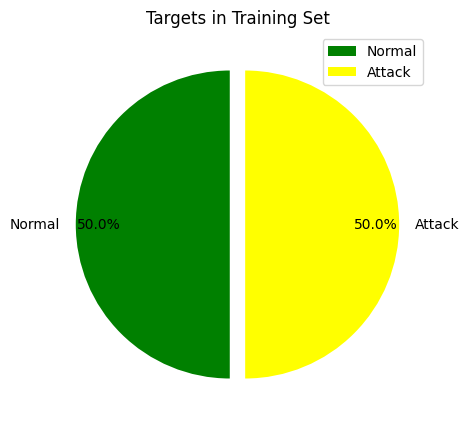

In [21]:
colors = ['Green', 'Yellow']
explode = (0.05,0.05)
plt.figure(figsize=(5, 5))
plt.pie(pd.Series(y_resampled).value_counts(), colors = colors, labels=['Normal', 'Attack'],
        autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
plt.legend()
plt.title("Targets in Training Set")
plt.show()


**HEATMAP AFTER BALANCING THE DATASET**

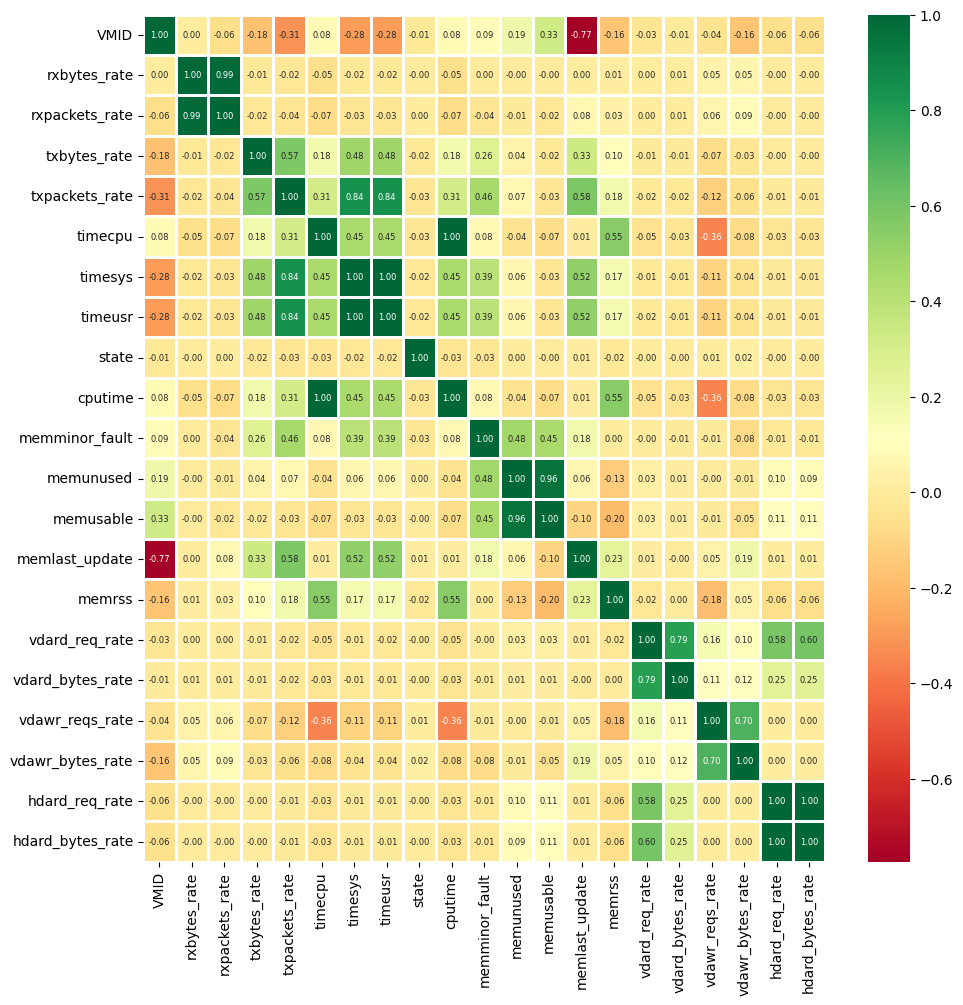

In [22]:
#Plot correlation matrix
plt.figure(figsize=(11, 11))
sns.heatmap(dfn.corr(), linewidth=1, annot=True,fmt=".2f",cmap="RdYlGn", annot_kws={"size":6})
plt.show()

In [23]:
# Convert the target variable to numeric before fitting the model
y_resampled = y_resampled.map({'Normal': 0, 'Attack': 1}).astype(int)
y_test = y_test.map({'Normal': 0, 'Attack': 1}).astype(int)

**FEATURE SCALING**

In [24]:
scaler= MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

In [25]:
# After scaling the feature names (column titles) will disapper,we need to restore them
feature_names = X.columns
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

**BUILDING A FFNN**

In [26]:
X_test_ffnn = X_test_scaled.copy()

In [27]:
ffnn_model= tf.keras.models.Sequential()
ffnn_model.add(tf.keras.layers.Dense(units=23, activation='relu'))
ffnn_model.add(tf.keras.layers.Dense(units=23, activation='relu'))
ffnn_model.add(tf.keras.layers.Dense(units=23, activation='relu'))
ffnn_model.add(tf.keras.layers.Dense(units=23, activation='relu'))
ffnn_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
ffnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
ffnn_model.fit(X_train_scaled, y_resampled, batch_size = 32, epochs = 5)

Epoch 1/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9017 - loss: 0.3239
Epoch 2/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9978 - loss: 0.0075
Epoch 3/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 9.8864e-04
Epoch 4/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9999 - loss: 7.2218e-04
Epoch 5/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 1.9215e-04


**MODEL EVALUATION**

In [28]:
# model evaluation for using the test dataset for the feedfoward neural network
ffnn_loss, ffnn_accuracy = ffnn_model.evaluate(X_test_scaled, y_test, verbose=0)
print ("Loss=%.4f" %ffnn_loss)
print ("Accuracy=%.4f" %ffnn_accuracy)

Loss=0.0001
Accuracy=1.0000


In [29]:
ffnn_predictions_val = ffnn_model.predict(X_test_scaled)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [30]:
y_predffnn = (ffnn_predictions_val > 0.5).astype(int)
report = classification_report(y_test, y_predffnn)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1444
           1       1.00      1.00      1.00       478

    accuracy                           1.00      1922
   macro avg       1.00      1.00      1.00      1922
weighted avg       1.00      1.00      1.00      1922



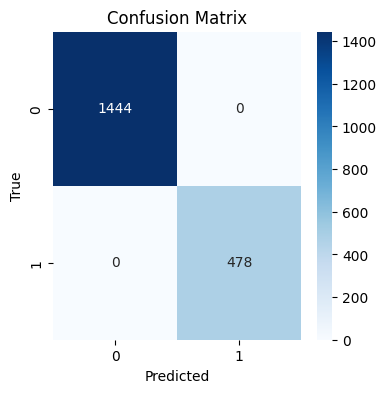

In [31]:
# Calculate confusion matrix
cnn_cm = confusion_matrix(y_test, y_predffnn)
# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**FEED FORWARD EXPLAINABILITY WITH LIME**

In [32]:
# train the blackbox (feed Foward Neural Network)
fnn_model = MLPClassifier(hidden_layer_sizes=(23,), max_iter=10, random_state=42)
fnn_model.fit(X_train_scaled, y_resampled)

MLPClassifier(hidden_layer_sizes=(23,), max_iter=10, random_state=42)

In [33]:
X_train_scaled.columns = pd.Index(X_train_scaled.columns)
feature_names = list(X_train_scaled.columns)

In [34]:
#lets convert the training set to  2D-array
X_train_scaled_np = X_train_scaled.to_numpy() # X-train
y_resampled_np = y_resampled.to_numpy()


In [35]:
#lets convert the testing set to  2D-array
X_test_scaled_np = X_test_scaled.to_numpy()  # X-test
y_test_np = y_test.to_numpy()                # y-test

In [36]:
# instantiating the expaliner for feedforward neural network using the LIME XAI technique
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_scaled_np, feature_names=feature_names,class_names = ['Normal','Attack'],verbose=True, mode='classification')
explainer

In [37]:
# Generate explanationsfor feedforward neural network
explanation = explainer.explain_instance(X_test_scaled_np[1],fnn_model.predict_proba,num_features=12)
explanation.show_in_notebook()

explanation = explainer.explain_instance(X_test_scaled_np[2],fnn_model.predict_proba,num_features=12)

explanation.show_in_notebook()
explanation = explainer.explain_instance(X_test_scaled_np[3],fnn_model.predict_proba,num_features=12)

explanation.show_in_notebook()

Intercept 0.6453032359552143
Prediction_local [-0.02469613]
Right: 0.006250846317873151


Intercept 0.7977425250913547
Prediction_local [-0.03808865]
Right: 0.006557410632282227


Intercept 0.6425712009418202
Prediction_local [0.08745625]
Right: 0.07499631952305726


  0%|          | 0/1922 [00:00<?, ?it/s]

Generating waterfall plot for instance 0


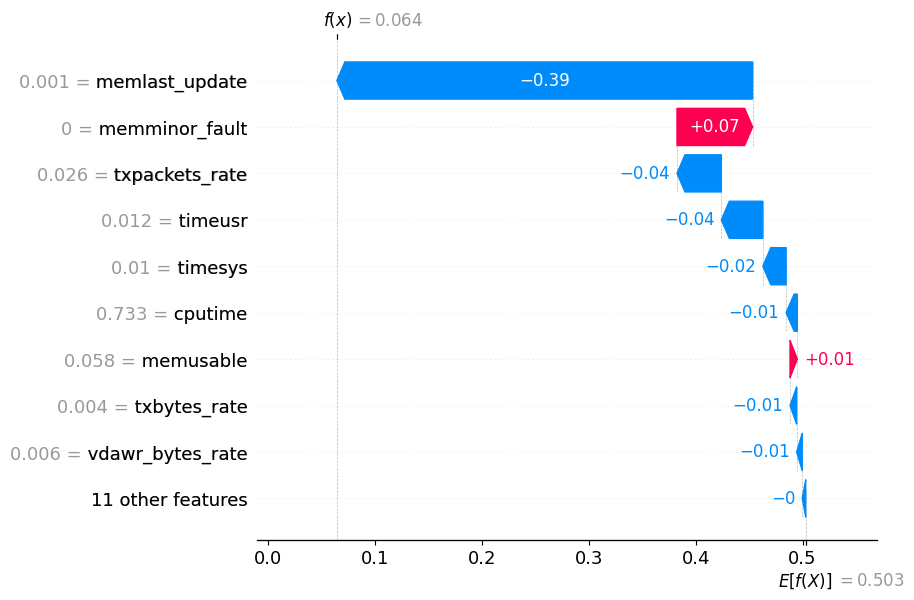

Generating waterfall plot for instance 1


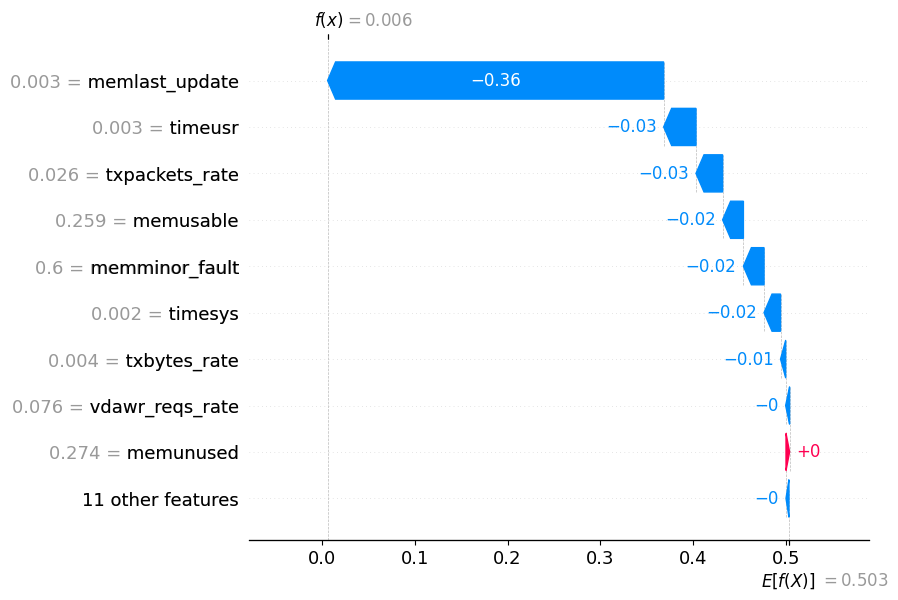

Generating waterfall plot for instance 2


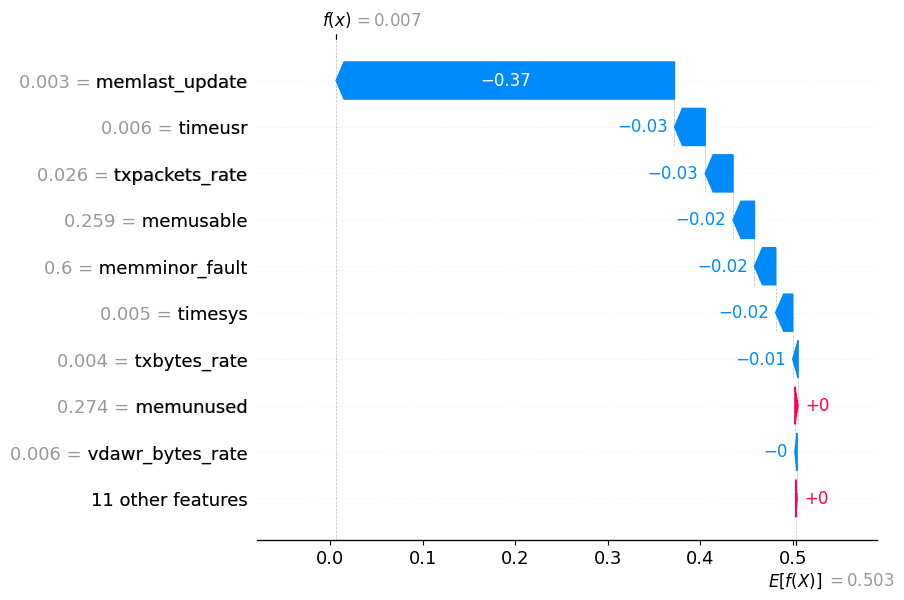

In [42]:
# Summarize the background data using k-means with K=100
K = 100  # Number of samples to use for background
background_data = shap.kmeans(X_train_scaled, K)  # Summarize background with k-means

# Initialize SHAP KernelExplainer with the summarized background data
explainer1 = shap.KernelExplainer(fnn_model.predict_proba, background_data)  # SHAP explainer for FFNN

# Generate SHAP values for the test set
shap_values = explainer1.shap_values(X_test_scaled_np)  # Pass the NumPy array

# Convert feature_names to a simple list if it's a Pandas Index
if isinstance(feature_names, pd.Index):
    feature_names = feature_names.tolist()

# Generate waterfall SHAP plots for specific instances
instance_indices = [0, 1, 2]  # Indices of the instances to visualize
for idx in instance_indices:
    print(f"Generating waterfall plot for instance {idx}")

    # Select SHAP values for the desired class (e.g., class 1 - Attack)
    class_idx = 1  # Index of the class to visualize (0 for Normal, 1 for Attack)
    shap_values_for_class = shap_values[idx][:, class_idx]  # Select SHAP values for the class

    # Assuming explainer1.expected_value is a 1D array with shape (n_classes,)
    base_value = explainer1.expected_value[class_idx]

    shap.waterfall_plot(
        shap.Explanation(values=shap_values_for_class,  # Use SHAP values for the specific class
                         base_values=base_value,
                         data=X_test_scaled_np[idx],
                         feature_names=feature_names)
    )

In [41]:
X_test_df = pd.DataFrame(X_test_scaled_np, columns=feature_names)  # Ensure feature names match
X_test_df['Target'] = y_test.values if hasattr(y_test, 'values') else y_test  # Add target column

# Display the first few rows for inspection
print(X_test_df.head())

# View a specific instance
instance_index = 1  # Example: View the second instance (index 1)
print(f"\nInstance {instance_index}:")
print(X_test_df.iloc[instance_index])

   rxbytes_rate  rxpackets_rate  txbytes_rate  txpackets_rate   timecpu  \
0      0.002761        0.006113      0.004265        0.025621  0.733027   
1      0.002766        0.006235      0.004265        0.025621  0.153403   
2      0.002762        0.006138      0.004265        0.025621  0.336739   
3      0.002763        0.006161      0.004265        0.025621  0.407653   
4      0.002762        0.006161      0.111861        0.705224  0.653769   

    timesys   timeusr  state   cputime  memminor_fault  ...  memusable  \
0  0.010210  0.011549    0.0  0.733027             0.0  ...   0.057554   
1  0.002074  0.003084    0.0  0.153403             0.6  ...   0.258993   
2  0.005402  0.006275    0.0  0.336739             0.6  ...   0.258993   
3  0.006007  0.006843    0.0  0.407653             0.0  ...   0.057554   
4  0.555328  0.557344    0.0  0.653769             0.8  ...   0.107914   

   memlast_update    memrss  vdard_req_rate  vdard_bytes_rate  \
0        0.000586  0.942544        0.00

**Global SHAP Interpretation Plot for the FFNN**

In [47]:
# Summarize the background data using k-means with K=100
K = 100  # Number of samples to use for background
background_data = shap.kmeans(X_train_scaled, K)  # Summarize background with k-means

# Initialize SHAP KernelExplainer with the summarized background data
explainer1 = shap.KernelExplainer(fnn_model.predict_proba, background_data)  # SHAP explainer for FFNN

# Generate SHAP values for the test set
shap_values = explainer1.shap_values(X_test_scaled_np)  # Pass the NumPy array

# Convert feature_names to a simple list if it's a Pandas Index
if isinstance(feature_names, pd.Index):
    feature_names = feature_names.tolist()

# Reshape shap_values to 2D if it's 3D (to ensure compatibility)
if shap_values.ndim == 3 and shap_values.shape[2] == 1:
    shap_values = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])

# Generate waterfall SHAP plots for specific instances
instance_indices = [1, 2, 3]  # Indices of the instances to visualize
for idx in instance_indices:
    print(f"Generating waterfall plot for instance {idx}")
    # Convert explainer.expected_value to a NumPy array if it's a Tensor
    if tf.is_tensor(explainer1.expected_value):
        base_value = explainer1.expected_value.numpy()
    else:
        base_value = explainer1.expected_value

    # Use the base_value (NumPy array or original value) for waterfall plot
    shap.waterfall_plot(
        shap.Explanation(values=shap_values[idx],
                         base_values=base_value, # Use the converted base_value
                         data=X_test_scaled_np[idx],
                         feature_names=feature_names)
    )

  0%|          | 0/1922 [00:00<?, ?it/s]

Generating waterfall plot for instance 1


ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (20, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

**COVOLUTIONAL NEURAL NETWORK IMPLEMENTATION**

In [125]:
# Re-shaping the features to be feed in the CNN -model

X_train_scaled = X_train_scaled.values.reshape(-1, X_train_scaled.shape[1], 1) # Use .values to get the NumPy array before reshaping
X_test_scaled = X_test_scaled.values.reshape(-1, X_test_scaled.shape[1], 1)   # Use .values to get the NumPy array before reshaping

# Build the CNN model
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(23, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(23, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(23, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# Compile the model
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
cnn_model.fit(X_train_scaled, y_resampled, batch_size = 32, epochs = 5)

Epoch 1/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8472 - loss: 0.3229
Epoch 2/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9974 - loss: 0.0099
Epoch 3/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9999 - loss: 0.0021
Epoch 4/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 9.0275e-04
Epoch 5/5
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 4.9837e-04


**MODEL EVALUATION-CNN**

In [126]:
# model evaluation for using the test dataset for the feedfoward neural network
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_scaled, y_test, verbose=0)
print ("Loss=%.4f" %cnn_loss)
print ("Accuracy=%.4f" %cnn_accuracy)

Loss=0.0007
Accuracy=1.0000


In [127]:
cnn_predictions = cnn_model.predict(X_test_scaled)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [128]:
y_predcnn = (cnn_predictions > 0.5).astype(int)
report_cnn = classification_report(y_test, y_predcnn)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1444
           1       1.00      1.00      1.00       478

    accuracy                           1.00      1922
   macro avg       1.00      1.00      1.00      1922
weighted avg       1.00      1.00      1.00      1922



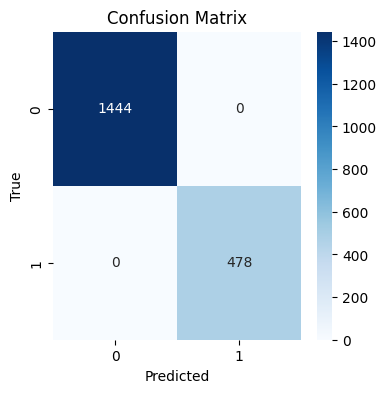

In [129]:
# Calculate confusion matrix
cnn_cm = confusion_matrix(y_test, y_predffnn)
# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# train the blackbox (Convoutional Neural Network)